# MLP GenCode 
Based on MLP_GenCode_110 which achieved high accuracy on GenCode.    
Now use simulated RNA to test the ORF effect.  
Use 128 neurons.  
Had to extend learning to more epochs.  


In [25]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-20 11:58:14 UTC


In [26]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=8000
NC_TESTS=8000   # Wen et al 2019 used 8000 and 2000 of each class
RNA_LEN=1000
MAX_K = 3
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.10
EPOCHS=300 # 25
SPLITS=5
FOLDS=5   # make this 5 for serious testing

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint


In [28]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [29]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")

2021-07-20 11:58:15 UTC
Generated 16000 PC seqs
Generated 16000 NC seqs


In [30]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 1000.0
Average ORF length: 675.03075
NC seqs
Average RNA length: 1000.0
Average ORF length: 179.96175
2021-07-20 11:58:32 UTC


## Data Prep

In [31]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 8000 8000
PC test, NC test: 8000 8000


In [32]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:3])
print(y[:3])
# Tests:
show_time()

['CGGTCCCCCCTGTCTTAAACGGGCATGTGATCTCTAGCCCATGACAGTTCGCTACGCCGCCGGTGCTATTGTCAACTGGTAGTAGCGTCAGCGTCATACTCGTCATCCTAGTCCTAAGTCCCGGGAGTCGAAGACCCAGAGCTTTCAAGAGCACCGAACAACTACATTCGACGCTTGGAGGTATAGAATAATTAGGAACCGGACTCAGTAAGACAGGATCATCAGCAGTTATCAAATAATATTGCGAGAGATGCGTTTGATTGGCGGATGTCTAGATGTTTGACAATGCCGAGCGCTAGTTGTGGATTTGGTTTATCGCAATATGTACTTGGTGGACGGGCGGTAGCCCGGGCTGTACGATCAAGTGAGCCATGCAGTGAGGGTTTATCCGCTCGTCTATTACTAACGCCTCAGGCGCCATATCTGCTGCTATTAAGGTATCATACAATAGTACTTGGCGGGAAGTGGTTTTTCACCCTTGGCGTAGGATGGCCTCGCCCGCGTTTTATAGCTCGTCGGCCCTCACTCCGCAATGGGAAACATTCGATTGAAAGTCCCCACCGATTGAGTATCCACGATTGTCGCAGCTATGTTGAGTCTAAATTGCAGCGATTGTGTGTGGAAAACACAGGCTGCTCTATACGGTTCCGTACCTCTAAGCCAGATGAGCAAAGCCTATGGACCCCTGACCGGTGTTCGGACACTATTAGATCCCGCACCCACTACAATTGATTGTGGTAGAATGGCCGTAGTAGAATGGCCGTAGACATGTCACTTAAGCTGCTTACCTAATTGTCCCTGTATAGAGCCGCTGACGCCTAGTTTGAAATTATTAGACGGGAGAGACCTTCCAACTATGTTCAATATCAAATTTTTCGCTTTTGGTGCTGGACTTTGAGCACGTAATGCGCCCGCTCCGCACGACCTCATTACACGGATTACTCATGGGACTTGAACTTAACCACCTAACGCGGTCAAAAAACGTATCTCTTCCACGA

In [33]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()

2021-07-20 11:58:41 UTC


## Neural network

In [34]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               10880     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS,shuffle=True)
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/300
400/400 [==============================] - 2s 3ms/step - loss: 0.7028 - accuracy: 0.5104 - val_loss: 0.6934 - val_accuracy: 0.5072
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 0.7027 - accuracy: 0.5053 - val_loss: 0.6930 - val_accuracy: 0.5072
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6982 - accuracy: 0.4947 - val_loss: 0.7015 - val_accuracy: 0.4928
Epoch 4/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6969 - accuracy: 0.5054 - val_loss: 0.6930 - val_accuracy: 0.5072
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6960 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.5072
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6941 - accuracy: 0.5071 - val_loss: 0.6959 - val_accuracy: 0.4928
Epoch 7/300
400/400 [==========================

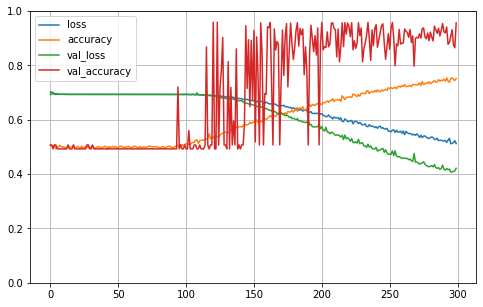

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/300
400/400 [==============================] - 2s 3ms/step - loss: 0.7082 - accuracy: 0.5072 - val_loss: 0.6942 - val_accuracy: 0.5003
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6990 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6980 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 4/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6975 - accuracy: 0.5146 - val_loss: 0.6933 - val_accuracy: 0.5003
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6958 - accuracy: 0.4978 - val_loss: 0.6937 - val_accuracy: 0.4997
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.4995 - val_loss: 0.6935 - val_accuracy: 0.5003
Epoch 7/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6948 - accuracy: 0.489

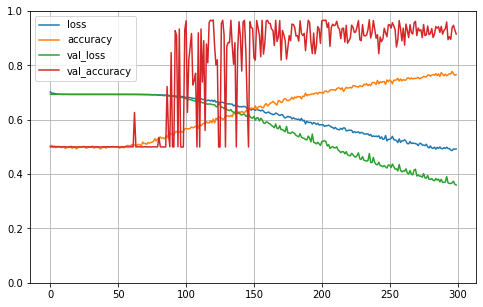

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/300
400/400 [==============================] - 2s 3ms/step - loss: 0.7092 - accuracy: 0.4955 - val_loss: 0.6942 - val_accuracy: 0.5038
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 0.7015 - accuracy: 0.4986 - val_loss: 0.6934 - val_accuracy: 0.4963
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6974 - accuracy: 0.4999 - val_loss: 0.6936 - val_accuracy: 0.4963
Epoch 4/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6971 - accuracy: 0.4837 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6962 - accuracy: 0.4955 - val_loss: 0.6938 - val_accuracy: 0.4963
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6941 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 7/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.493

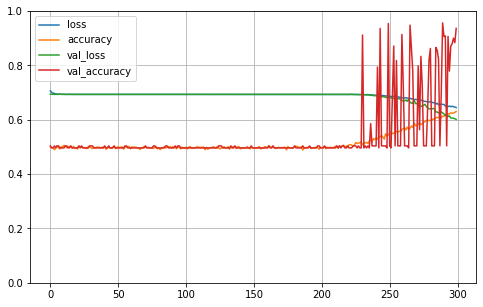

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/300
400/400 [==============================] - 2s 3ms/step - loss: 0.7024 - accuracy: 0.5120 - val_loss: 0.7165 - val_accuracy: 0.4947
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 0.7038 - accuracy: 0.4969 - val_loss: 0.6957 - val_accuracy: 0.4947
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6975 - accuracy: 0.5048 - val_loss: 0.6934 - val_accuracy: 0.5053
Epoch 4/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6960 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4947
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6961 - accuracy: 0.4935 - val_loss: 0.6951 - val_accuracy: 0.4947
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6953 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 7/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6942 - accuracy: 0.504

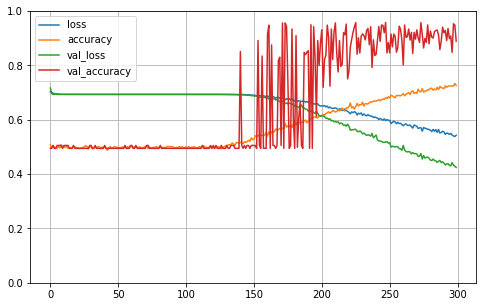

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/300
400/400 [==============================] - 2s 3ms/step - loss: 0.7203 - accuracy: 0.4961 - val_loss: 0.6959 - val_accuracy: 0.5053
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6993 - accuracy: 0.5052 - val_loss: 0.7104 - val_accuracy: 0.4947
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6988 - accuracy: 0.5053 - val_loss: 0.6941 - val_accuracy: 0.4947
Epoch 4/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6976 - accuracy: 0.4982 - val_loss: 0.6937 - val_accuracy: 0.5053
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6952 - accuracy: 0.5025 - val_loss: 0.6975 - val_accuracy: 0.5053
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6955 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.4947
Epoch 7/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6944 - accuracy: 0.500

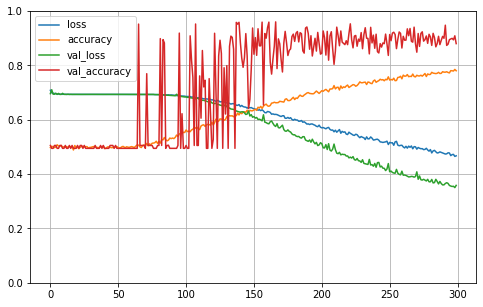

In [36]:
do_cross_validation(Xfrq,y)

In [37]:
from keras.models import load_model
print(pc_train[0])
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[0])
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[0])
X=Xfrq
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

CGGTCCCCCCTGTCTTAAACGGGCATGTGATCTCTAGCCCATGACAGTTCGCTACGCCGCCGGTGCTATTGTCAACTGGTAGTAGCGTCAGCGTCATACTCGTCATCCTAGTCCTAAGTCCCGGGAGTCGAAGACCCAGAGCTTTCAAGAGCACCGAACAACTACATTCGACGCTTGGAGGTATAGAATAATTAGGAACCGGACTCAGTAAGACAGGATCATCAGCAGTTATCAAATAATATTGCGAGAGATGCGTTTGATTGGCGGATGTCTAGATGTTTGACAATGCCGAGCGCTAGTTGTGGATTTGGTTTATCGCAATATGTACTTGGTGGACGGGCGGTAGCCCGGGCTGTACGATCAAGTGAGCCATGCAGTGAGGGTTTATCCGCTCGTCTATTACTAACGCCTCAGGCGCCATATCTGCTGCTATTAAGGTATCATACAATAGTACTTGGCGGGAAGTGGTTTTTCACCCTTGGCGTAGGATGGCCTCGCCCGCGTTTTATAGCTCGTCGGCCCTCACTCCGCAATGGGAAACATTCGATTGAAAGTCCCCACCGATTGAGTATCCACGATTGTCGCAGCTATGTTGAGTCTAAATTGCAGCGATTGTGTGTGGAAAACACAGGCTGCTCTATACGGTTCCGTACCTCTAAGCCAGATGAGCAAAGCCTATGGACCCCTGACCGGTGTTCGGACACTATTAGATCCCGCACCCACTACAATTGATTGTGGTAGAATGGCCGTAGTAGAATGGCCGTAGACATGTCACTTAAGCTGCTTACCTAATTGTCCCTGTATAGAGCCGCTGACGCCTAGTTTGAAATTATTAGACGGGAGAGACCTTCCAACTATGTTCAATATCAAATTTTTCGCTTTTGGTGCTGGACTTTGAGCACGTAATGCGCCCGCTCCGCACGACCTCATTACACGGATTACTCATGGGACTTGAACTTAACCACCTAACGCGGTCAAAAAACGTATCTCTTCCACGAGA

predictions.shape (16000, 1)
first prediction [0.02790604]


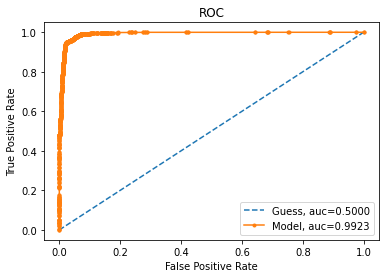

AUC: 99.23%


In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first prediction",bm_probs[0])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))
